# Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_feather('../input/training-data-to-feather-python-r-low-mem/train.feather')

# A first look over the data

Getting an idea of how many observations, assets and time steps

In [3]:
obs = train.shape[0]
print(f"number of observations: {obs}")

number of observations: 3141410


In [4]:
time_steps, assets = train.time_id.nunique(), train.investment_id.nunique()
print(f"number of assets: {assets} \t time steps: {time_steps}")

number of assets: 3579 	 time steps: 1211


In [5]:
print(f"number of assets: {assets} (range from {train.investment_id.min()} to {train.investment_id.max()})")

number of assets: 3579 (range from 0 to 3773)


The range of assets is more extended than the number fo assets themselves. In fact, assets will change in part in the test set, therefore you have to consider strategies for handling the ones in the training set in a generalizable way.
See: https://www.kaggle.com/c/ubiquant-market-prediction/discussion/301693#1656092

# Target analysis

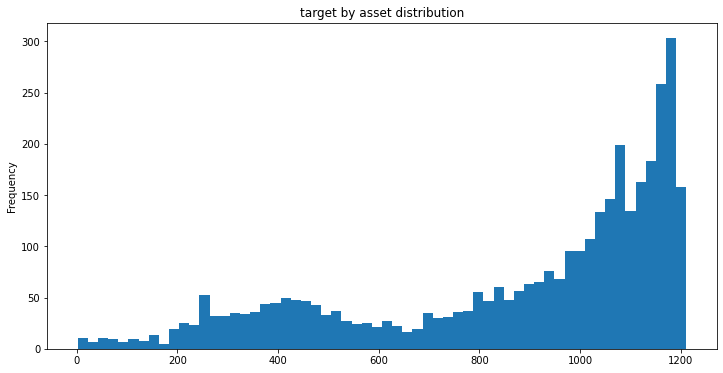

In [6]:
obs_by_asset = train.groupby(['investment_id'])['target'].count()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
obs_by_asset.plot.hist(bins=60)
plt.title("target by asset distribution")
plt.show()

If you more carefully look at the fabric of assets by time, you will notice, quite a few discontinuitites and that the discontinuities are more present in the first section of the time.

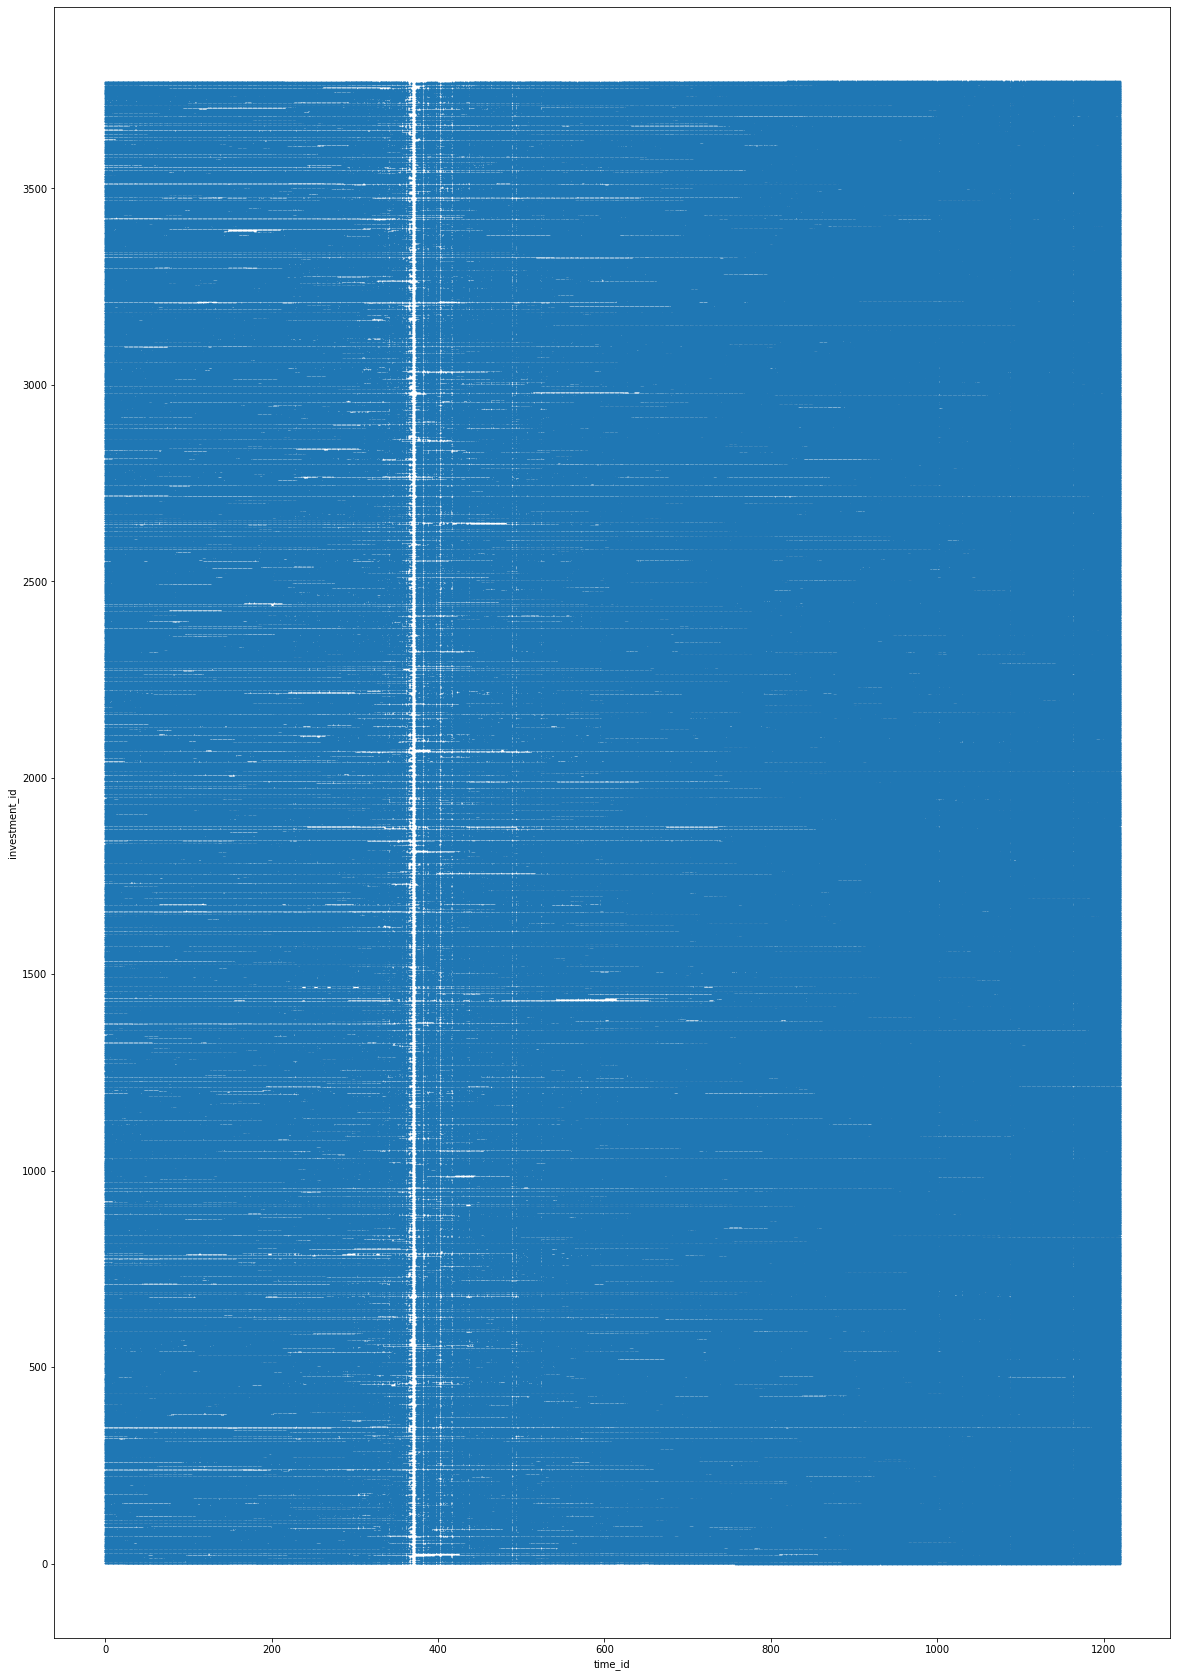

In [7]:
train[['investment_id', 'time_id']].plot.scatter('time_id', 'investment_id', figsize=(20, 30), s=0.5)
plt.show()

Assets are distributed in a different way, there are assets that are actually more frequently observed and others that are not. **A good cv and modelling strategy should keep this into account** (stratify if you are working with subsamples).

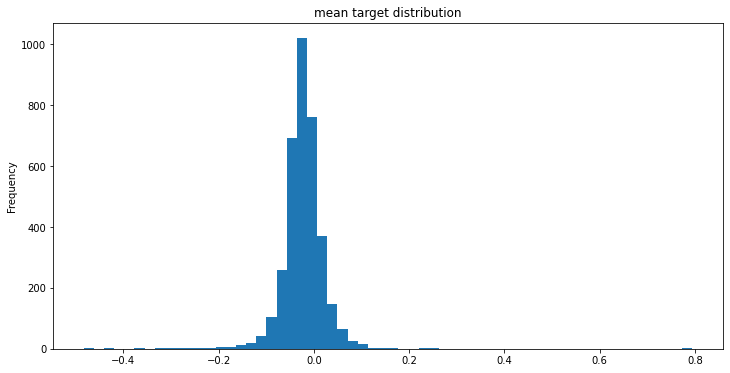

Mean of mean target: -0.02310


In [8]:
mean_target = train.groupby(['investment_id'])['target'].mean()
mean_mean_target = np.mean(mean_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
mean_target.plot.hist(bins=60)
plt.title("mean target distribution")
plt.show()

print(f"Mean of mean target: {mean_mean_target: 0.5f}")

The average of mean target by asset show a bell-shaped distribution, beware that there are outliers, anyway, because there are some assets with quite negative average target (-0.4 area) and some quite positive ones (+0.8 area). Overall the average mean target by asset is slightly negative (-0.0231)

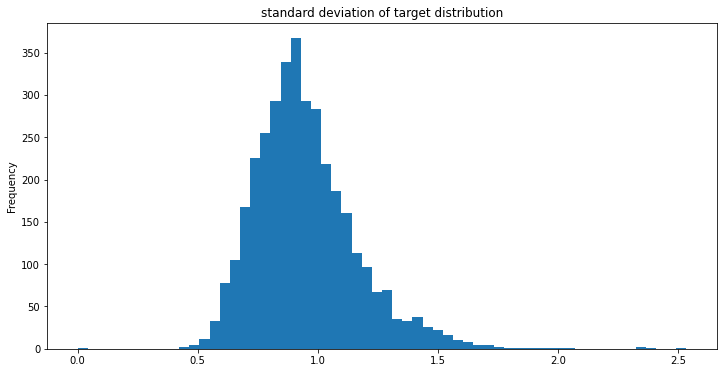

Mean of std target:  0.94790


In [9]:
sts_target = train.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(sts_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sts_target.plot.hist(bins=60)
plt.title("standard deviation of target distribution")
plt.show()

print(f"Mean of std target: {mean_std_target: 0.5f}")

Also the average of mean standard deviation (std) by asset presents some interesting patterns. First of all, it is skewed toward the right, with some assets having more std (up to 2.5). On the other side there are also some few assets with std almost at zero.

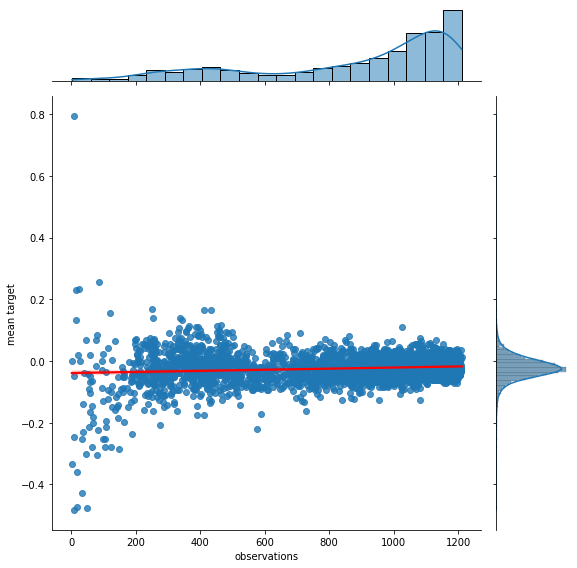

In [10]:
ax = sns.jointplot(x=obs_by_asset, y=mean_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('mean target')
plt.show()

By jointly plotting the distribution of observartions by asset and the mean target value by asset, we may notice that the target value slightly reduces proportionally to the number of observation. The dispersion of values tends to grow with less observations, hence we need to re-plot the scatterplot this time using the standard deviation.

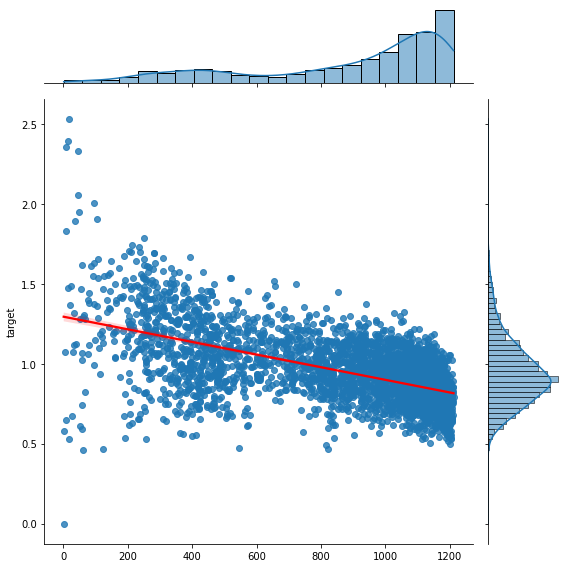

In [11]:
qx = sns.jointplot(x=obs_by_asset.values, y=sts_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('std target')
plt.show()

The new scatterplot reveals that the less the observations, imply a much more uncertainty in the mean target. Since the mechanism o 

**Strategy**: in training you need to control this effect by expliciting the number of observations because this is predictive of the uncertainty of the predictions. In the test phase, instead, when you are working with an asset that you don't know about, you need to impute an average number of observations, thus expecting an average dispersion of predictions for that asset.

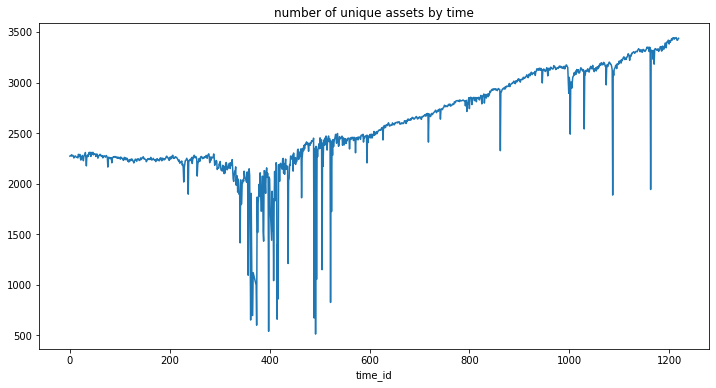

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
train.groupby('time_id')['investment_id'].nunique().plot()
plt.title("number of unique assets by time")
plt.show()

As we have reasoned how the investments with less observations seem more risky, we notice how the number of the assets present at each time step is quite different and also highly oscillating. By the end of the avaliable time, the number of assets has grown by one third.

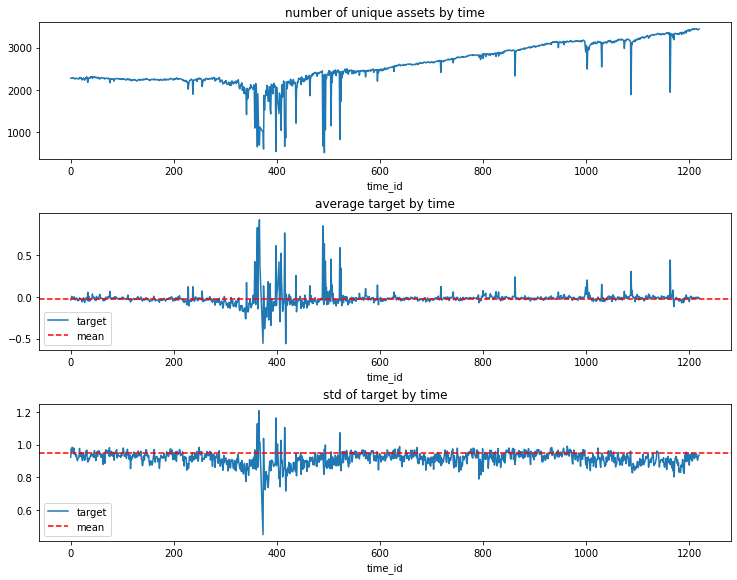

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1,)
(train.groupby('time_id')['investment_id'].nunique()).plot()
plt.title("number of unique assets by time")

plt.subplot(3, 1, 2)
train.groupby('time_id')['target'].mean().plot()
plt.title("average target by time")
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.subplot(3, 1, 3)
train.groupby('time_id')['target'].std().plot()
plt.title("std of target by time")
plt.axhline(y=mean_std_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [14]:
r = np.corrcoef(train.groupby('time_id')['investment_id'].nunique(), train.groupby('time_id')['target'].mean())[0][1]
print(f"Correlation of number of assets by target: {r:0.3f}")

Correlation of number of assets by target: -0.184


If we plot the number of assets by time alongside the average target by time, it becomes evident that when there are less assets, the target oscillates more with prevalently higher targets. The correlation of assets number and target is negative, in fact. I wonder if we are modelling the asset allocation strategies alongside the markets. 

Let's now observe more closely the relationship between target and time:

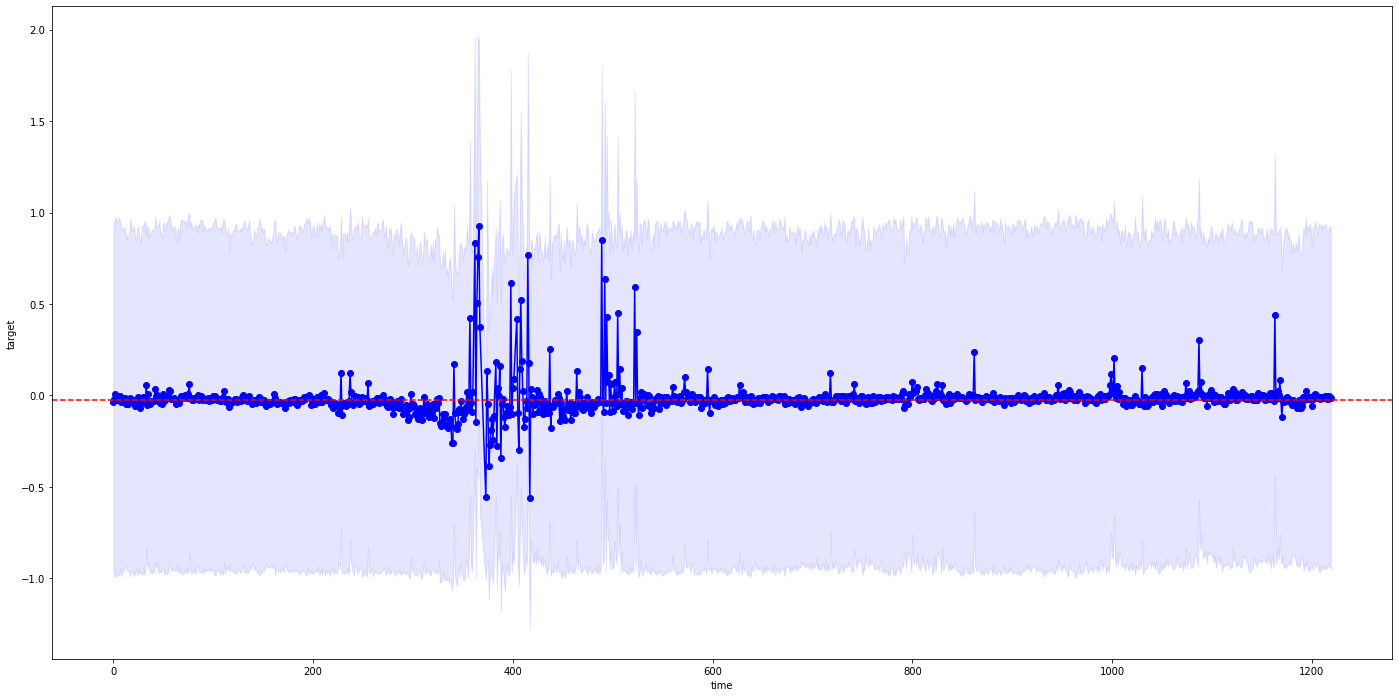

In [15]:
time2target_mean = train.groupby(['time_id'])['target'].mean()
time2target_std = train.groupby(['time_id'])['target'].std()

_, axes = plt.subplots(1, 1, figsize=(24, 12))
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )
plt.plot(
        time2target_mean.index, time2target_mean, "o-", color="b", label="Training score"
    )
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")
axes.set_ylabel("target")
axes.set_xlabel("time")
plt.show()

Clearly the target is detrended and forced to mean zero and unit standard deviation, though at times when the number of assets is reduced the average changes and consequently shifts also the confidence interval. Being able to figure out such times of mean shift in the test set could be quite advantageous.

Basically, this chart is the key. The task of the competition is to find out the position of an asset in a day. Is the asset near the average or how much is far away from it (you are predicting volatility, basically). In fact the evaluation is based on the mean of the Pearson correlation coefficient for each time ID.

In the following chart we are overimposing the target for asset 70 with the market average and the unit standard deviation band.

Clearly the position of asset 70 depends on its performance but also on the way the mean and standard deviation for that period_id is calculated (are we analyzing the volatility inside a basket of investment, maybe?).

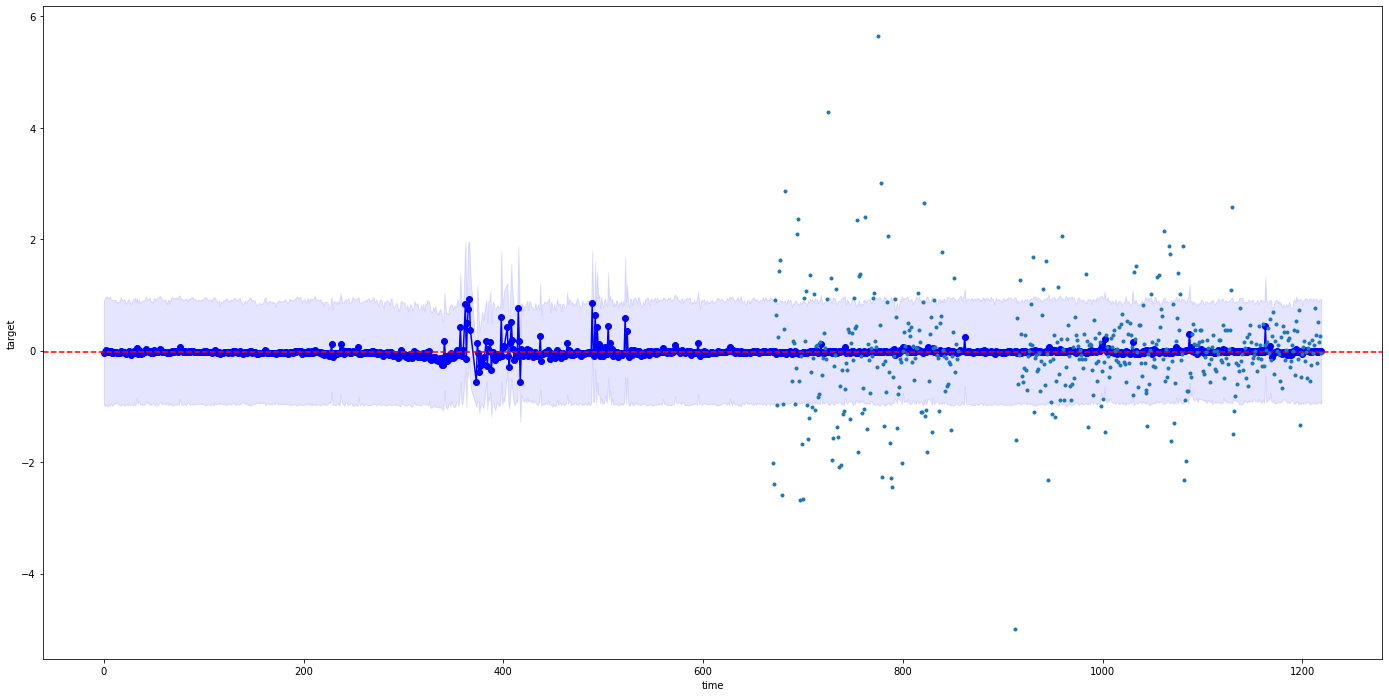

In [16]:
time2target_mean = train.groupby(['time_id'])['target'].mean()
time2target_std = train.groupby(['time_id'])['target'].std()

_, axes = plt.subplots(1, 1, figsize=(24, 12))
plt.fill_between(
        time2target_mean.index,
        time2target_mean - time2target_std,
        time2target_mean + time2target_std,
        alpha=0.1,
        color="b",
    )
plt.plot(
        time2target_mean.index, time2target_mean, "o-", color="b", label="Training score"
    )
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label="mean")

asset = 70
plt.plot(train[train.investment_id==asset].time_id,
               train[train.investment_id==asset].target, '.')

axes.set_ylabel("target")
axes.set_xlabel("time")
plt.show()

**Strategy**: now your cv strategy should be clear, you have to do groupkfold on the time_id, keeping all the assets realtive to a time_id or in train or in validation.